In [ ]:
import sys
sys.path.append('..')

import numpy as np
import matplotlib.pyplot as plt
import torch
import warnings
from gpytorch.kernels import MaternKernel, ScaleKernel, RQKernel
import matplotlib as mpl
from BO_loop import BO_loop_GP, GP_Wrapper
from data import BayesOptDataset, FuncAckley, FuncGriewank, FuncAckleyKRY
from sklearn.preprocessing import MinMaxScaler
import copy
from matplotlib.lines import Line2D
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.gridspec as gridspec

warnings.filterwarnings('ignore')

In [ ]:
func = {
    'name': "FuncAckleyKRY",
    'function': FuncAckleyKRY
}

In [6]:
# Set random seeds
SEED = 0
np.random.seed(SEED)
torch.manual_seed(SEED)

KERNEL_FLAGS = {
    "mat52": {"kernel": "mat52", "set_ls": False, "if_ard": False},
    "mat12": {"kernel": "mat12", "set_ls": False, "if_ard": False},
    "rq":    {"kernel": "rq",    "set_ls": False, "if_ard": False},
    "gcauchy": {"kernel": "gcauchy", "set_ls": False, "if_ard": False}
}

# Define consistent colors
colors_dict = {
    "gp_mean": "#1f77b4",       # blue
    "true_func": "#000000",     # black
    "samples": "#2ca02c",       # green
    "global_min": "#d62728",    # red
    "fill": "#1f77b4",          # same as gp_mean, but transparent
}

Generating 2D plots for Ackley function...
Cloning
[GP_Wrapper.step] 1000 epochs: 77.151075 → 1.272469 (Δ=75.878606, rel=98.35%)
[GP_Wrapper.step] 2000 epochs: 77.151075 → 1.272317 (Δ=75.878758, rel=98.35%)
Seed: 0 --- Kernel: mat52 --- itr: 21: best before=-9.329257739663902, best after=-7.611744002713666, curr query: [-7.611744], time=5.048s
Saved hyperparameters to /home/jimmy/abhigya/BayesOpt/hyperparams/Ackley/mat52/hyperparams_Ackley_mat52_seed0.csv
[GP_Wrapper.step] 50 epochs: 1.125127 → 1.098830 (Δ=0.026297, rel=2.34%)
Seed: 0 --- Kernel: mat52 --- itr: 22: best before=-7.611744002713666, best after=-5.88299596836676, curr query: [-5.88299597], time=0.277s
Saved hyperparameters to /home/jimmy/abhigya/BayesOpt/hyperparams/Ackley/mat52/hyperparams_Ackley_mat52_seed0.csv
[GP_Wrapper.step] 50 epochs: 0.953740 → 0.922072 (Δ=0.031668, rel=3.32%)
Seed: 0 --- Kernel: mat52 --- itr: 23: best before=-5.88299596836676, best after=-5.66334106456906, curr query: [-5.66334106], time=0.253s
S

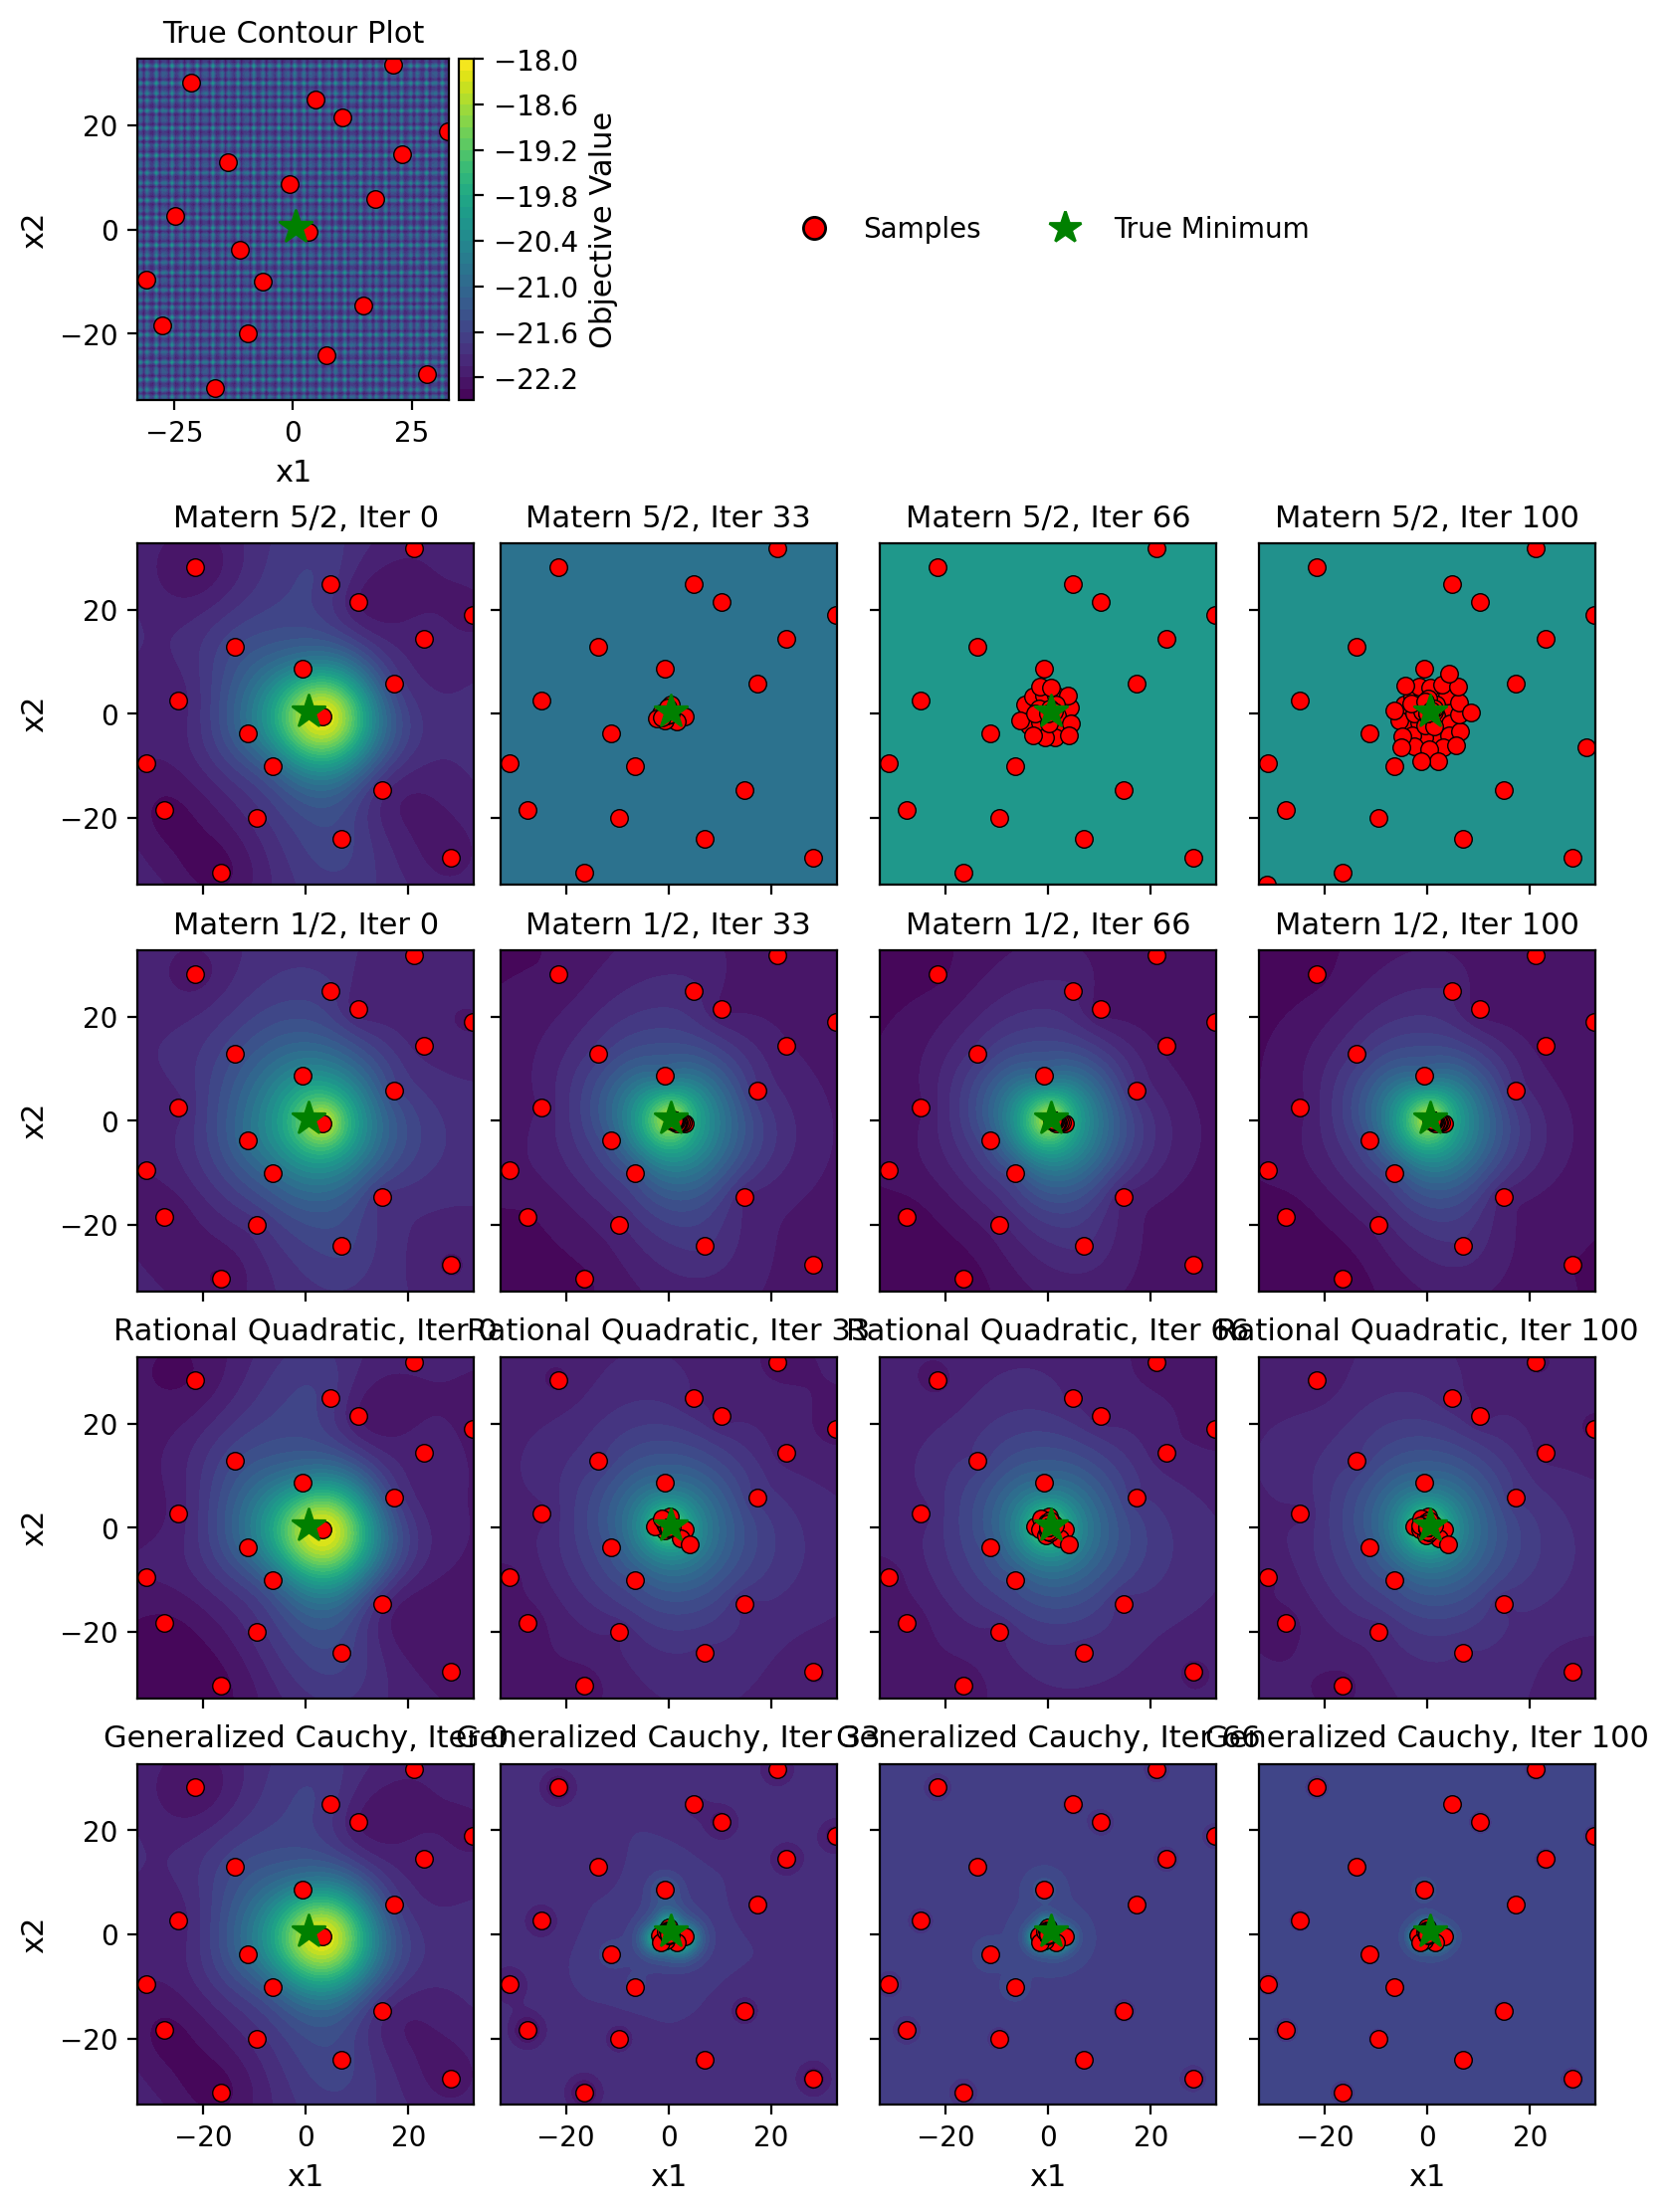

In [7]:
def BO_UCB_plot_grid(kernel_types, kernel_names, dataset, total_iter=15, beta=1.5):
    # Configure plotting style
    mpl.rcParams.update({
        'font.family': 'sans-serif',
        'font.sans-serif': ['Arial', 'DejaVu Sans', 'Liberation Sans'],
        'font.size': 11,
        'axes.labelsize': 11,
        'axes.titlesize': 11,
        'xtick.labelsize': 10,
        'ytick.labelsize': 10,
        'legend.fontsize': 10,
        'figure.titlesize': 11,
        'figure.dpi': 200
    })

    num_rows = len(kernel_types)
    milestones = [0, total_iter // 3, 2 * total_iter // 3, total_iter]
    num_cols = len(milestones)

    fig = plt.figure(figsize=(8, 2.5 * num_rows + 1), constrained_layout=True, dpi=200)
    gs = gridspec.GridSpec(num_rows + 1, num_cols,
                           height_ratios=[1] + [1] * num_rows,
                           figure=fig)
                           
    # Get true function values for plotting
    lb = dataset.func.lb
    ub = dataset.func.ub
    X_plot = np.linspace(lb[0], ub[0], 100)
    Y_plot = np.linspace(lb[1], ub[1], 100)
    X_grid, Y_grid = np.meshgrid(X_plot, Y_plot)
    XY_grid = np.column_stack((X_grid.ravel(), Y_grid.ravel()))
    Z_true = dataset.func.query(XY_grid).reshape(X_grid.shape)
    
    # True contour plot (using original scale)
    ax_true = fig.add_subplot(gs[0, 0])
    cntr = ax_true.contourf(X_grid, Y_grid, Z_true, levels=30, cmap='viridis')
    
    x_init_denorm = dataset.func.inputs_scaler.inverse_transform(dataset.X)
    ax_true.scatter(x_init_denorm[:, 0], x_init_denorm[:, 1], c='red', edgecolors='k', s=40, linewidth=0.5)
    
    x_true_min_denorm, _ = dataset.func.get_opts()
    ax_true.scatter(x_true_min_denorm[:, 0], x_true_min_denorm[:, 1], c='green', marker='*', s=150)
    
    ax_true.set_title("True Contour Plot")
    ax_true.set_xlabel("x1")
    ax_true.set_ylabel("x2")

    divider = make_axes_locatable(ax_true)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    cbar = fig.colorbar(cntr, cax=cax)
    cbar.set_label("Objective Value")
    
    # Legend in the top row
    legend_ax = fig.add_subplot(gs[0, 1:])
    legend_ax.axis('off')
    handles = [
        plt.Line2D([], [], marker='o', linestyle='', color='red', markeredgecolor='k', markersize=8, label='Samples'),
        plt.Line2D([], [], marker='*', linestyle='', color='green', markersize=12, label='True Minimum')
    ]
    legend_ax.legend(handles=handles, loc='center', frameon=False, ncol=2)

    for i, kernel_type in enumerate(kernel_types):
        current_dataset = dataset.clone()
        flags = KERNEL_FLAGS[kernel_type]
        base_kern = flags["kernel"]
        set_ls = flags["set_ls"]
        if_ard = flags["if_ard"]

        X_init, Y_init = current_dataset.get_data(normalize=True)
        gp_model = GP_Wrapper(
            X_init, Y_init,
            kernel=base_kern,
            if_ard=if_ard,
            if_softplus=True,
            set_ls=set_ls,
            device="cpu",
        )
        gp_model.init_optimizer(lr=0.1, optim="ADAM")
        gp_model.step(epochs=1000)

        for j, n in enumerate(milestones):
            if n > 0:
                BO_loop_GP(
                    func_name="Ackley",
                    dataset=current_dataset,
                    seed=SEED,
                    num_step=n - milestones[j-1],
                    beta=beta,
                    if_ard=if_ard,
                    if_softplus=True,
                    acqf_type="UCB",
                    set_ls=set_ls,
                    kernel_type=base_kern,
                    full_kernel_name=kernel_type,
                    device="cpu"
                )
                X, Y = current_dataset.get_data(normalize=True)
                gp_model.update_train_data(X, Y)
                gp_model.step(epochs=50)

            ax = fig.add_subplot(gs[i + 1, j])

            mu, _ = plot_gp_state_2d(gp_model, dataset, X_grid, Y_grid, ax)
            cntr_gp = ax.contourf(X_grid, Y_grid, mu, levels=30, cmap='viridis')
            
            X_denorm = dataset.func.inputs_scaler.inverse_transform(current_dataset.X)
            ax.scatter(X_denorm[:, 0], X_denorm[:, 1], c='red', edgecolors='k', s=40, linewidth=0.5)

            x_true_min_denorm, _ = dataset.func.get_opts()
            ax.scatter(x_true_min_denorm[:, 0], x_true_min_denorm[:, 1], c='green', marker='*', s=150)

            ax.set_title(f"{kernel_names[i]}, Iter {n}")
            
            if i == num_rows - 1:
                ax.set_xlabel("x1")
            else:
                ax.set_xticklabels([])
            
            if j == 0:
                ax.set_ylabel("x2")
            else:
                ax.set_yticklabels([])

    plt.show()
    plt.close()

def plot_gp_state_2d(gp, dataset, X_grid, Y_grid, ax):
    gp.gp_model.eval()
    gp.likelihood.eval()
    
    XY_grid = np.column_stack((X_grid.ravel(), Y_grid.ravel()))
    XY_grid_norm = dataset.func.inputs_scaler.transform(XY_grid)
    
    with torch.no_grad():
        posterior = gp.likelihood(gp.gp_model(torch.tensor(XY_grid_norm)))
    
    mu_norm = posterior.mean.numpy()
    mu = mu_norm * dataset.scaler.scale_[0] + dataset.scaler.mean_[0]
    mu = mu.reshape(X_grid.shape)
    
    return mu, None

if __name__ == "__main__":
    #func_2d = FuncGriewank(dim=2, maximize=False)
    func_2d = FuncAckley(dim=2)
    dataset_2d = BayesOptDataset(func_2d, n_init=20, method='lhs', seed=SEED)
    
    kernel_types = ["mat52", "mat12", "rq","gcauchy"]
    kernel_names = ["Matern 5/2", "Matern 1/2", "Rational Quadratic","Generalized Cauchy"]

    print("Generating 2D plots for Ackley function...")
    BO_UCB_plot_grid(
        kernel_types=kernel_types,
        kernel_names=kernel_names,
        dataset=dataset_2d,
        total_iter=100,
        beta=1.5
    )